In [ ]:
# uploaded 2m_temperature_5.625deg dataset to Google Drive

from google.colab import drive
drive.mount('/content/drive')

!pip install xarray torch-harmonics matplotlib

import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import torch
import torch_harmonics as th
import matplotlib.pyplot as plt

In [ ]:
!pip install cartopy

In [4]:
import cartopy.crs as ccrs

In [5]:
# Load the dataset

# we will use the 2018 dataset, 5.625 deg resolution
dataset_path = '/content/drive/MyDrive/Climate_GraphODE/data/2m_temperature_5.625deg/2m_temperature_2018_5.625deg.nc'
ds = xr.open_dataset(dataset_path)

# Inspect the dataset structure
print(ds)

temperature = ds['t2m'].isel(time=0).values
lat = ds['lat'].values
lon = ds['lon'].values


<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 8760)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-06 10:38:21 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...


Static Visualization

In [6]:
temperature = temperature - 273.15 #convert to Celsius

In [7]:
import torch
import torch.nn as nn
import torch.fft as fft
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

cmap = 'turbo'

In [8]:
from torch_harmonics import *

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
data = nn.functional.interpolate(torch.from_numpy(temperature).unsqueeze(0).unsqueeze(0), size=(512,2*512)).squeeze()

In [11]:
signal = data.to(device)

In [12]:
n_theta = data.shape[0]
n_lambda = data.shape[1]


In [13]:
sht = RealSHT(n_theta, n_lambda, grid="equiangular").to(device)
isht = InverseRealSHT(n_theta, n_lambda, grid="equiangular").to(device)

In [14]:
coeffs = sht(signal)

In [15]:
lon = np.linspace(-np.pi, np.pi, n_lambda)
lat = np.linspace(np.pi/2., -np.pi/2., n_theta)
Lon, Lat = np.meshgrid(lon, lat)

In [16]:
import matplotlib.pyplot as plt

In [ ]:
!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

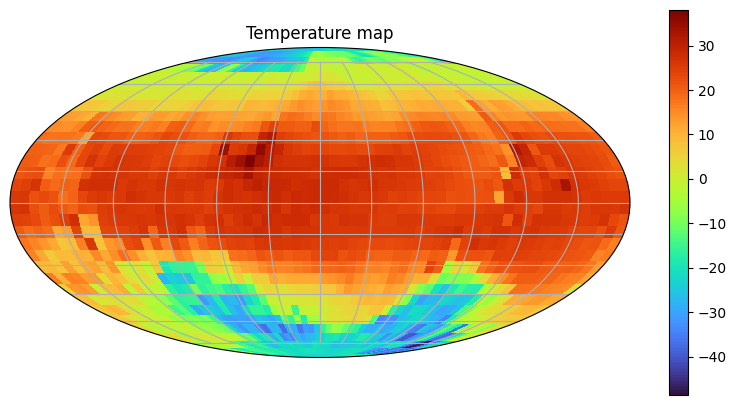

In [18]:
# visualization of the temperature on midnight of Jan 1st, 2018

fig = plt.figure(figsize=(22, 5))
ax = fig.add_subplot(1, 2, 2, projection='mollweide')
plt.pcolormesh(Lon, Lat, isht(coeffs).cpu(), cmap=cmap)
ax.set_title("Temperature map")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.colorbar()
plt.show()

Animation

In [19]:

temperature_visual = []
for i in range(10):
  temp = ds['t2m'].isel(time=i).values
  data = nn.functional.interpolate(torch.from_numpy(temp).unsqueeze(0).unsqueeze(0), size=(512,2*512)).squeeze()
  temperature_visual.append(data)

temperature_visual = np.array(temperature_visual)

In [20]:
import torch

# Assuming data can be either a NumPy array or a PyTorch tensor
if torch.is_tensor(temperature_visual):
    if temperature_visual.is_cuda:
        temperature_visual = temperature_visual.cpu()
else:
    # Convert NumPy array to tensor and move to CPU
    temperature_visual = torch.from_numpy(temperature_visual).cpu()


In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from math import ceil, floor

import sys

from torch_harmonics.sht import *
from torch_harmonics.examples import ShallowWaterSolver

In [22]:
nlat = 512
nlon = 2*nlat
lmax = ceil(128)
mmax = lmax
dt = 75

# ShallowWaterSolver has a function plot_griddata that plots 2D data to the
# surface of a sphere
swe_solver = ShallowWaterSolver(nlat, nlon, dt, lmax=lmax, mmax=mmax).to(device)

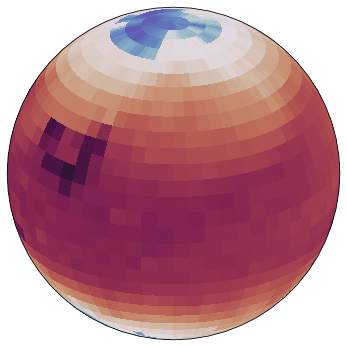

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Visualizing the first ten hours of 2018
fig = plt.figure(figsize=(8, 6), dpi=72)
moviewriter = animation.writers['pillow'](fps=5)
moviewriter.setup(fig, './temperature_animation.gif', dpi=72)

for i in range(temperature_visual.shape[0]):
    plt.clf()
    swe_solver.plot_griddata(temperature_visual[i], fig, cmap="twilight_shifted", antialiased=False)
    plt.draw()
    moviewriter.grab_frame()

moviewriter.finish()